# Librerías

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf


import missingno as msno
import re, unicodedata
import nltk
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import plot_roc_curve

pd.options.display.max_colwidth = 150

# Funciones

In [2]:
def clean_words(text):
    res = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    res = re.sub("[^a-zA-Z0-9 ]"," ", res.decode("utf-8"), flags=re.UNICODE)
    res = u' '.join(res.lower().split())
    return res

In [3]:
def metricas(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

# Datos

In [4]:
train = pd.read_csv("fake_news_train.csv")
test = pd.read_csv("fake_news_test.csv")
print(train.shape)
print(test.shape)

(35918, 5)
(8980, 3)


In [5]:
train.head()

,title,text,subject,date,fake_not
0,Barca's Valverde skirts independence debate as Iniesta ruled out for Bilbao,"MADRID, (Reuters) - Barcelona boss Ernesto Valverde declined to be drawn on Friday on whether a declaration of independence by Catalonia s parliam...",worldnews,"October 27, 2017",0
1,Trump says Brexit wouldn't impact potential UK-U.S. trade deal if he is president: ITV,LONDON (Reuters) - Presumptive U.S. Republican presidential nominee Donald Trump said Britain leaving the European Union would make no difference ...,politicsNews,"May 15, 2016",0
2,Mark Zuckerberg’s PERFECT Facebook Comment To Grandmother Proves He’s A Badass Feminist,"There are seldom people in life that you can honestly say are solidly good people, but Mark Zuckerberg is one of those few that could fall into th...",News,"January 4, 2016",1
3,"Suspected U.S. drone targets Haqqani militants in Pakistan, killing four","DERA ISMAIL KHAN, Pakistan (Reuters) - A suspected U.S. drone strike on Thursday targeted a hideout of the Haqqani militant network along Pakistan...",worldnews,"November 30, 2017",0
4,U.S. special envoy encouraged that Kurds could embrace plan to delay referendum,"ERBIL (Reuters) - Brett McGurk, the U.S. special envoy to the coalition against Islamic State, on Thursday said he was encouraged that the Iraqi K...",worldnews,"September 14, 2017",0


In [6]:
train["fake_not"].value_counts()

1    18778
0    17140
Name: fake_not, dtype: int64

<AxesSubplot:>

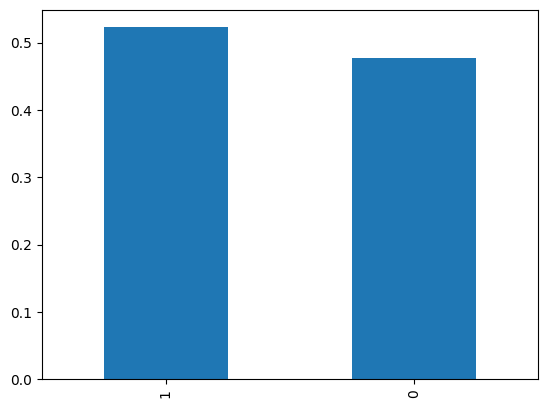

In [58]:
train["fake_not"].value_counts(True).plot(kind="bar")

In [7]:
test.head()

,title,text,subject
0,Vietnam police arrest ex-politburo member over misconduct,HANOI (Reuters) - Vietnamese police on Friday arrested a former top Communist Party official suspected of misconduct while he was chairman of the ...,worldnews
1,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of Liberal Murdoch Sons Blamed For Firing Of Bill O’Reilly…TRASH Trump On Social Media,It is difficult to exaggerate the significance of Fox News sacking of Bill O Reilly.Not only was he the single most dominant public figure in Amer...,left-news
2,North Carolina Tea Partiers Just ADMITTED They Are The True Terrorists; Trump Administration Does Nothing,"Since Donald Trump began his run for the president, there has been one clear message: if you aren t white (preferably male) and Christian, you are...",News
3,Apparently The Speaker Of The House Is Now Taking Advice From Kanye West (TWEET),"Just when you thought Republicans couldn t get any worse, they go and endorse something Kanye West says. And not just any Republican, mind you, Sp...",News
4,HUH? NYT EDITOR Blames “Republican Rage Machine” for Current Political Climate [Video],"Talk about projecting! On Fareed Zakaria s CNN show, former New York Times editor Jill Abramson decries false equivalency between Democrats and ...",politics


<AxesSubplot:>

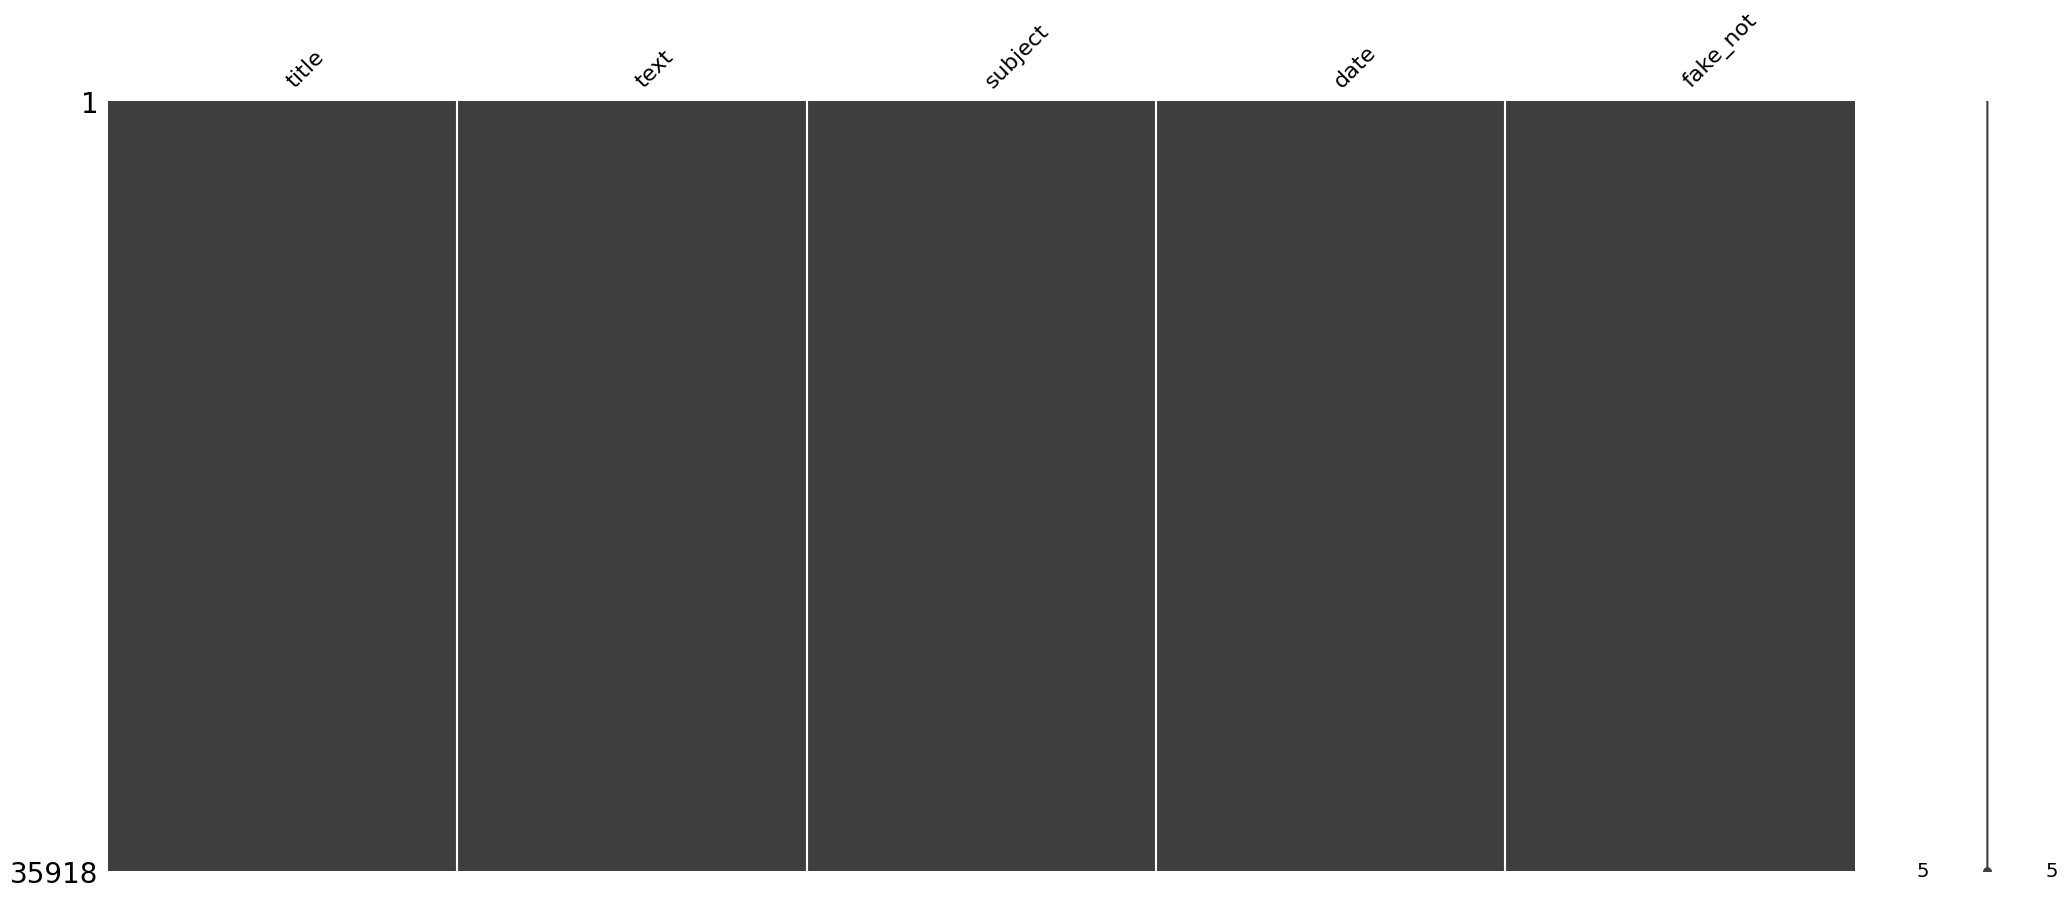

In [8]:
msno.matrix(train)

<AxesSubplot:>

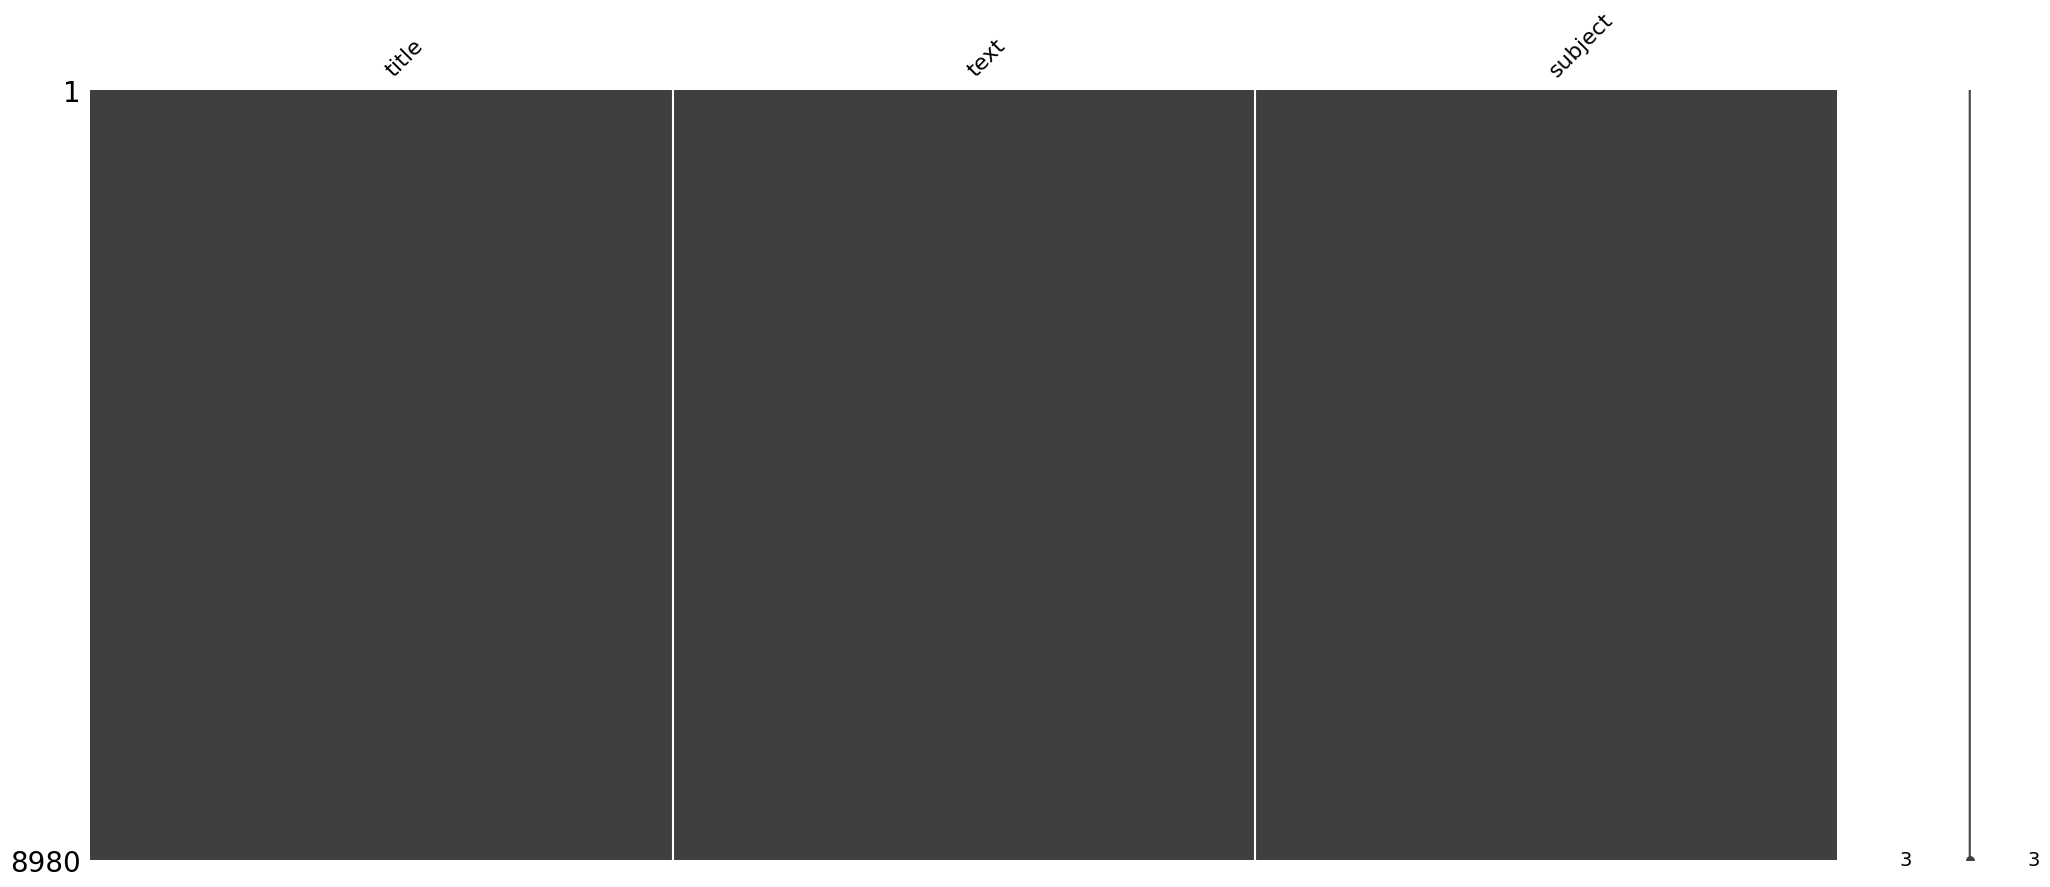

In [9]:
msno.matrix(test)

<AxesSubplot:>

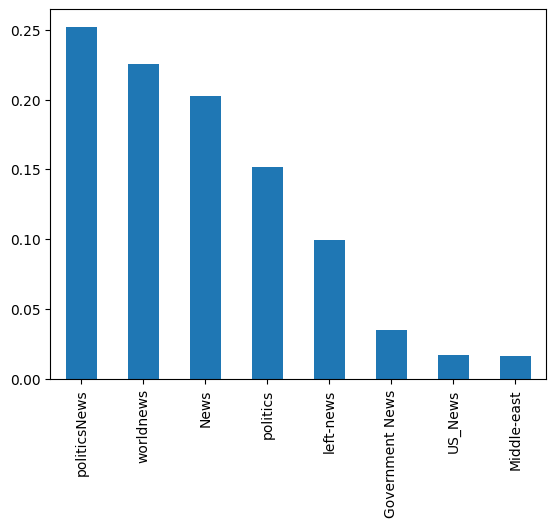

In [10]:
train["subject"].value_counts(True).plot(kind="bar") # Agrupar

<AxesSubplot:>

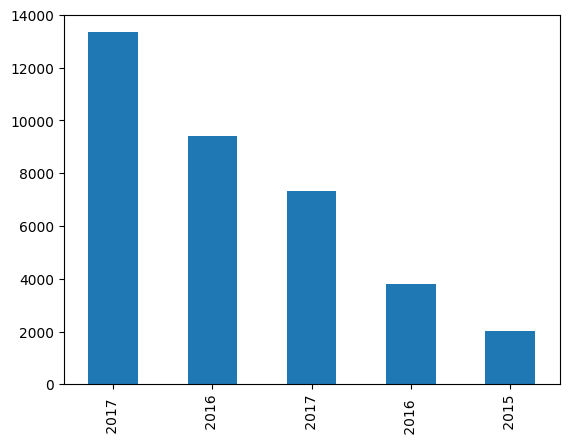

In [61]:
train["date"].str.split(",", expand=True)[1].value_counts().plot(kind="bar")

# Limpieza 

In [12]:
train['title'] = train['title'].map(lambda x: x.replace("U.S.", 'US'))
train['text'] = train['text'].map(lambda x: x.replace("U.S.", 'US'))

In [13]:
train['clean_title'] = train['title'].map(clean_words)

In [14]:
train['clean_text'] = train['text'].map(clean_words)

In [15]:
train.head()

,title,text,subject,date,fake_not,clean_title,clean_text
0,Barca's Valverde skirts independence debate as Iniesta ruled out for Bilbao,"MADRID, (Reuters) - Barcelona boss Ernesto Valverde declined to be drawn on Friday on whether a declaration of independence by Catalonia s parliam...",worldnews,"October 27, 2017",0,barca s valverde skirts independence debate as iniesta ruled out for bilbao,madrid reuters barcelona boss ernesto valverde declined to be drawn on friday on whether a declaration of independence by catalonia s parliament m...
1,Trump says Brexit wouldn't impact potential UK-US trade deal if he is president: ITV,LONDON (Reuters) - Presumptive US Republican presidential nominee Donald Trump said Britain leaving the European Union would make no difference to...,politicsNews,"May 15, 2016",0,trump says brexit wouldn t impact potential uk us trade deal if he is president itv,london reuters presumptive us republican presidential nominee donald trump said britain leaving the european union would make no difference to a p...
2,Mark Zuckerberg’s PERFECT Facebook Comment To Grandmother Proves He’s A Badass Feminist,"There are seldom people in life that you can honestly say are solidly good people, but Mark Zuckerberg is one of those few that could fall into th...",News,"January 4, 2016",1,mark zuckerbergs perfect facebook comment to grandmother proves hes a badass feminist,there are seldom people in life that you can honestly say are solidly good people but mark zuckerberg is one of those few that could fall into tha...
3,"Suspected US drone targets Haqqani militants in Pakistan, killing four","DERA ISMAIL KHAN, Pakistan (Reuters) - A suspected US drone strike on Thursday targeted a hideout of the Haqqani militant network along Pakistan s...",worldnews,"November 30, 2017",0,suspected us drone targets haqqani militants in pakistan killing four,dera ismail khan pakistan reuters a suspected us drone strike on thursday targeted a hideout of the haqqani militant network along pakistan s moun...
4,US special envoy encouraged that Kurds could embrace plan to delay referendum,"ERBIL (Reuters) - Brett McGurk, the US special envoy to the coalition against Islamic State, on Thursday said he was encouraged that the Iraqi Kur...",worldnews,"September 14, 2017",0,us special envoy encouraged that kurds could embrace plan to delay referendum,erbil reuters brett mcgurk the us special envoy to the coalition against islamic state on thursday said he was encouraged that the iraqi kurdish l...


In [16]:
train['article'] = train['title'] + train['text']
train['clean_article'] = train['clean_title'] + train['clean_text']

In [17]:
train['n_words'] = train['article'].str.split().map(len)

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidrinconmorales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopwords = stopwords.words('english')

In [20]:
train['n_letters'] = train['article'].map(lambda x: sum(map(str.isalpha, x)))
train['n_lower_ratio_letters'] = train['article'].map(lambda x: sum(map(str.islower, x))) / train['n_letters']
train['n_upper_ratio_letters'] = train['article'].map(lambda x: sum(map(str.isupper, x))) / train['n_letters']

In [21]:
train['n_upper_ratio_letters'].loc[(train.n_upper_ratio_letters>0.2)] 

26       0.202586
148      0.203125
231      0.256410
318      0.480392
343      0.282895
           ...   
35782    0.448276
35786    0.263566
35805    0.351351
35836    0.247475
35853    0.412214
Name: n_upper_ratio_letters, Length: 1371, dtype: float64

In [22]:
train['n_upper_ratio_letters'].loc[(train.n_upper_ratio_letters>0.2) & (train.fake_not==1)]

26       0.202586
148      0.203125
231      0.256410
318      0.480392
343      0.282895
           ...   
35782    0.448276
35786    0.263566
35805    0.351351
35836    0.247475
35853    0.412214
Name: n_upper_ratio_letters, Length: 1369, dtype: float64

<AxesSubplot:>

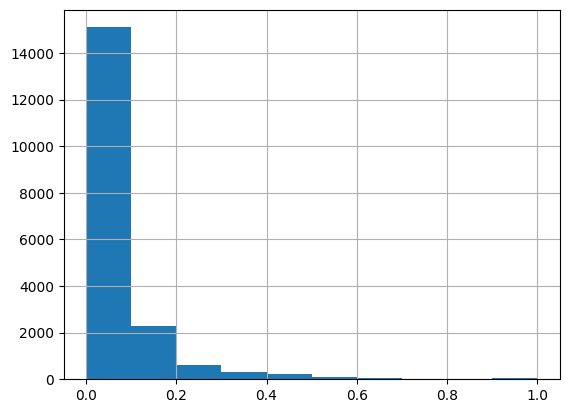

In [23]:
train['n_upper_ratio_letters'].loc[train['fake_not']==1].hist()

<AxesSubplot:>

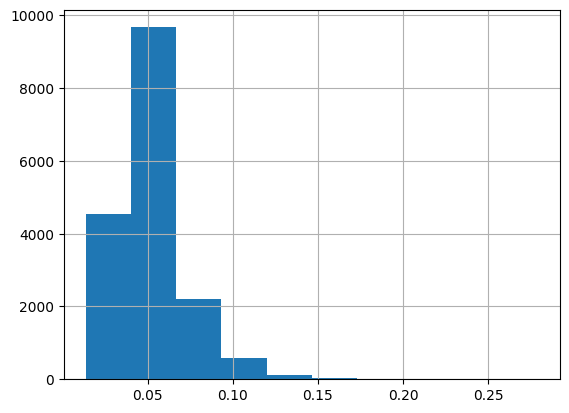

In [24]:
train['n_upper_ratio_letters'].loc[train['fake_not']==0].hist()

In [25]:
train.head()

,title,text,subject,date,fake_not,clean_title,clean_text,article,clean_article,n_words,n_letters,n_lower_ratio_letters,n_upper_ratio_letters
0,Barca's Valverde skirts independence debate as Iniesta ruled out for Bilbao,"MADRID, (Reuters) - Barcelona boss Ernesto Valverde declined to be drawn on Friday on whether a declaration of independence by Catalonia s parliam...",worldnews,"October 27, 2017",0,barca s valverde skirts independence debate as iniesta ruled out for bilbao,madrid reuters barcelona boss ernesto valverde declined to be drawn on friday on whether a declaration of independence by catalonia s parliament m...,"Barca's Valverde skirts independence debate as Iniesta ruled out for BilbaoMADRID, (Reuters) - Barcelona boss Ernesto Valverde declined to be draw...",barca s valverde skirts independence debate as iniesta ruled out for bilbaomadrid reuters barcelona boss ernesto valverde declined to be drawn on ...,347,1638,0.953602,0.046398
1,Trump says Brexit wouldn't impact potential UK-US trade deal if he is president: ITV,LONDON (Reuters) - Presumptive US Republican presidential nominee Donald Trump said Britain leaving the European Union would make no difference to...,politicsNews,"May 15, 2016",0,trump says brexit wouldn t impact potential uk us trade deal if he is president itv,london reuters presumptive us republican presidential nominee donald trump said britain leaving the european union would make no difference to a p...,Trump says Brexit wouldn't impact potential UK-US trade deal if he is president: ITVLONDON (Reuters) - Presumptive US Republican presidential nomi...,trump says brexit wouldn t impact potential uk us trade deal if he is president itvlondon reuters presumptive us republican presidential nominee d...,148,653,0.920368,0.079632
2,Mark Zuckerberg’s PERFECT Facebook Comment To Grandmother Proves He’s A Badass Feminist,"There are seldom people in life that you can honestly say are solidly good people, but Mark Zuckerberg is one of those few that could fall into th...",News,"January 4, 2016",1,mark zuckerbergs perfect facebook comment to grandmother proves hes a badass feminist,there are seldom people in life that you can honestly say are solidly good people but mark zuckerberg is one of those few that could fall into tha...,Mark Zuckerberg’s PERFECT Facebook Comment To Grandmother Proves He’s A Badass FeministThere are seldom people in life that you can honestly say ...,mark zuckerbergs perfect facebook comment to grandmother proves hes a badass feministthere are seldom people in life that you can honestly say are...,387,1882,0.945271,0.054729
3,"Suspected US drone targets Haqqani militants in Pakistan, killing four","DERA ISMAIL KHAN, Pakistan (Reuters) - A suspected US drone strike on Thursday targeted a hideout of the Haqqani militant network along Pakistan s...",worldnews,"November 30, 2017",0,suspected us drone targets haqqani militants in pakistan killing four,dera ismail khan pakistan reuters a suspected us drone strike on thursday targeted a hideout of the haqqani militant network along pakistan s moun...,"Suspected US drone targets Haqqani militants in Pakistan, killing fourDERA ISMAIL KHAN, Pakistan (Reuters) - A suspected US drone strike on Thursd...",suspected us drone targets haqqani militants in pakistan killing fourdera ismail khan pakistan reuters a suspected us drone strike on thursday tar...,290,1530,0.945098,0.054902
4,US special envoy encouraged that Kurds could embrace plan to delay referendum,"ERBIL (Reuters) - Brett McGurk, the US special envoy to the coalition against Islamic State, on Thursday said he was encouraged that the Iraqi Kur...",worldnews,"September 14, 2017",0,us special envoy encouraged that kurds could embrace plan to delay referendum,erbil reuters brett mcgurk the us special envoy to the coalition against islamic state on thursday said he was encouraged that the iraqi kurdish l...,"US special envoy encouraged that Kurds could embrace plan to delay referendumERBIL (R

In [26]:
cv = TfidfVectorizer(stop_words = stopwords, ngram_range=(1,1), min_df = 10, max_features=100)

In [27]:
feat = ['n_words', 'n_letters', 'n_lower_ratio_letters', 'n_upper_ratio_letters']

In [28]:
X = train[feat + ['clean_article']]
y = train['fake_not']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [30]:
cv.fit(X_train['clean_article'])

TfidfVectorizer(max_features=100, min_df=10,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [31]:
X_train = X_train[feat].join(pd.DataFrame(data = cv.transform(X_train['clean_article']).todense(), 
                                          columns= cv.get_feature_names_out(),
                                          index=X_train.index))

In [32]:
X_test = X_test[feat].join(pd.DataFrame(data = cv.transform(X_test['clean_article']).todense(), 
                                          columns= cv.get_feature_names_out(),
                                          index=X_test.index))

In [33]:
kb = SelectKBest(k = 10, score_func = f_classif)
kb.fit(X_train, y_train)

SelectKBest()

In [34]:
best = [x for x, y in zip(X_train.columns, kb.get_support()) if y]

In [35]:
best

['n_lower_ratio_letters',
 'n_upper_ratio_letters',
 'even',
 'know',
 'like',
 'reuters',
 'said',
 'us',
 'via',
 'video']

In [36]:
X_train = X_train[best]

In [37]:
bayes = MultinomialNB()

In [38]:
bayes.fit(X_train, y_train)

MultinomialNB()

In [39]:
metricas(bayes, X_train, y_train)

 Roc Validate: 0.986
 Acc Validate: 0.946
 Matrix Conf Validate:  
 [[11562   469]
 [  878 12233]]


In [40]:
scores = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, estimator=bayes, scoring="roc_auc")

In [41]:
scores

array([0.98720597, 0.98633084, 0.98589685, 0.98447046])

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



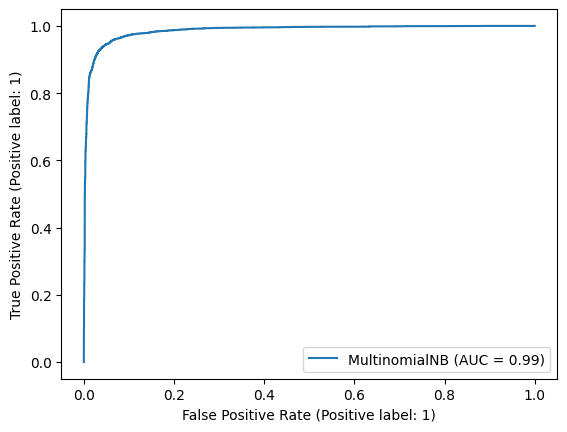

In [42]:
plot_roc_curve(bayes, X_test[best], y_test, drop_intermediate=False)

# Testing

In [43]:
test['article'] = test['title'] + test['text']
test['clean_article'] = test['title'].map(clean_words) + test['text'].map(clean_words)

In [44]:
test['n_words'] = test['article'].str.split().map(len)

In [45]:
test['n_letters'] = test['article'].map(lambda x: sum(map(str.isalpha, x)))
test['n_lower_ratio_letters'] = test['article'].map(lambda x: sum(map(str.islower, x))) / test['n_letters']
test['n_upper_ratio_letters'] = test['article'].map(lambda x: sum(map(str.isupper, x))) / test['n_letters']

In [46]:
X = test[feat + ['clean_article']]

In [47]:
cv.fit(X['clean_article'])

TfidfVectorizer(max_features=100, min_df=10,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [48]:
X = X[feat].join(pd.DataFrame(data = cv.transform(X['clean_article']).todense(), 
                                          columns= cv.get_feature_names_out(),
                                          index=X.index))

In [49]:
X['video'] = 0

In [50]:
bayes.predict(X[best])

array([0, 1, 1, ..., 0, 1, 1])

In [51]:
test['predicted'] = bayes.predict(X[best])

In [52]:
test[['article', 'predicted']]

,article,predicted
0,Vietnam police arrest ex-politburo member over misconductHANOI (Reuters) - Vietnamese police on Friday arrested a former top Communist Party offic...,0
1,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of Liberal Murdoch Sons Blamed For Firing Of Bill O’Reilly…TRASH Trump On Social MediaIt is difficult to...,1
2,North Carolina Tea Partiers Just ADMITTED They Are The True Terrorists; Trump Administration Does NothingSince Donald Trump began his run for the...,1
3,"Apparently The Speaker Of The House Is Now Taking Advice From Kanye West (TWEET)Just when you thought Republicans couldn t get any worse, they go...",1
4,"HUH? NYT EDITOR Blames “Republican Rage Machine” for Current Political Climate [Video]Talk about projecting! On Fareed Zakaria s CNN show, former ...",1
...,...,...
8975,McConnell says U.S. debt ceiling debate could stretch into SeptemberWASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell on Tuesday ...,0
8976,Kuwait court sentences MPs to jail terms for storming into parliamentKUWAIT (Reuters) - A Kuwaiti court handed several lawmakers jail terms on Mon...,0
8977,Democrat wins by one vote in Virginia legislative election recount (Corrects spelling of Virginia House of Delegates member David Yancey throughou...,0
8978,"THE NEW SWEDEN: Rapes, Riots, Severed Heads, Freeloading Foreigners And Shocking AcquittalsThe consequences of throwing out the welcome mat for pe...",1


In [53]:
bayes.predict(X[best]).size

8980

In [54]:
bayes.predict(X[best]).sum()

4519

In [55]:
#4468 Real
#4512 Fake